# Embeddings Comparison

The idea is that we want to see if BERT produces ultrametric-like embeddings. Probabilistically, it should.

We create NUMBER_OF_TRIALS trials. Each trial has between FEWEST_EXEMPLARS and MOST_EXAMPLARS exemplars randomly
selected from monosemous (single-meaning) words.

For each trial we look at the whole vocabulary, and assign each word in the vocabulary to the nearest exemplar.
We do this using wordnet (path similarity) and BERT (using Euclidean distance). Hopefully one day I'll turn this
into something p-adic too.

Should I use Resnik similarity?

In [3]:
NUMBER_OF_TRIALS = 10
FEWEST_EXEMPLARS = 5
MOST_EXEMPLARS = 100

In [4]:
import nltk
from nltk.corpus import wordnet as wn
import random
import torch
from transformers import BertTokenizer, BertModel
import tqdm
import collections
from scipy.spatial.distance import cosine

In [5]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Copied from https://towardsdatascience.com/3-types-of-contextualized-word-embeddings-from-bert-using-transfer-learning-81fcefe3fe6d
    
    Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

In [67]:
%%time
monosemous_nouns = {}
for word in wn.all_lemma_names():
    synsets = wn.synsets(word)
    if len(synsets) == 1 and synsets[0].pos() == 'n':
        word_fragments = word.split('_')
        all_fragments_in_bert = True
        for fragment in word_fragments:
            if word not in tokenizer.vocab:
                all_fragments_in_bert = False
                break
        if not all_fragments_in_bert:
            continue
        monosemous_nouns[word] = synsets[0]

CPU times: user 1.43 s, sys: 5.53 ms, total: 1.43 s
Wall time: 1.43 s


In [68]:
monosemous_nouns_list = list(monosemous_nouns)
len(monosemous_nouns_list)

2917

In [69]:
working_subset_of_nouns = random.sample(monosemous_nouns_list, MOST_EXEMPLARS * 5)

In [74]:
bert_embeddings = {}
for word in working_subset_of_nouns:
    marked_text = "[CLS] "
    marked_text += word.replace('_', ' ')
    marked_text += " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    list_token_embeddings = get_bert_embeddings(tokens_tensor, segments_tensors, model)
    bert_embeddings[word] = tokens_tensor

In [73]:
bert_embeddings

{'monte': tensor([[  101, 10125,   102]]),
 'tay': tensor([[  101, 28117,   102]]),
 'wembley': tensor([[  101, 16538,   102]]),
 'zambia': tensor([[  101, 15633,   102]]),
 'carolina': tensor([[ 101, 3792,  102]]),
 'messenger': tensor([[  101, 11981,   102]]),
 'magnum': tensor([[  101, 19691,   102]]),
 'literacy': tensor([[ 101, 8433,  102]]),
 'expertise': tensor([[  101, 11532,   102]]),
 'burnham': tensor([[  101, 25295,   102]]),
 'rio': tensor([[ 101, 5673,  102]]),
 'mandolin': tensor([[  101, 17687,   102]]),
 'flea': tensor([[  101, 26735,   102]]),
 'delhi': tensor([[ 101, 6768,  102]]),
 'mcgraw': tensor([[  101, 24179,   102]]),
 'qi': tensor([[  101, 18816,   102]]),
 'sa': tensor([[ 101, 7842,  102]]),
 'pali': tensor([[  101, 28619,   102]]),
 'rockies': tensor([[  101, 22366,   102]]),
 'opportunity': tensor([[ 101, 4495,  102]]),
 'waterfront': tensor([[  101, 16317,   102]]),
 'patio': tensor([[  101, 19404,   102]]),
 'nobleman': tensor([[  101, 18487,   102]]),
 

In [36]:
trials = []
for trial_number in tqdm.tqdm(range(NUMBER_OF_TRIALS)):
    exemplar_count = random.randrange(FEWEST_EXEMPLARS, MOST_EXEMPLARS)
    exemplar_words = random.sample(working_subset_of_nouns, k=exemplar_count)
    exemplar_synsets = [monosemous_nouns[w] for w in exemplar_words]
    exemplars = {w:s for (w,s) in zip(exemplar_words, exemplar_synsets)}
    wordnet_neighbours = {}
    for word, synset in monosemous_nouns.items():
        if word not in working_subset_of_nouns:
            continue
        best_exemplar = None
        best_score = 0.0
        for e_word, e_synset in exemplars.items():
            similarity = max(wn.path_similarity(synset, e_synset), wn.path_similarity(e_synset, synset))
            if similarity > best_score:
                best_exemplar = e_word
                best_score = similarity
        wordnet_neighbours[word] = best_exemplar
    trial = {'exemplar_count': exemplar_count,
            'exemplar_words': exemplar_words,
            'wordnet_neighbours': wordnet_neighbours}
    trials.append(trial)

100%|███████████████████████████████████████████| 10/10 [00:35<00:00,  3.56s/it]


In [37]:
trials

[{'exemplar_count': 53,
  'exemplar_words': ['filename_extension',
   'genus_utricularia',
   'mightiness',
   'sanitary_condition',
   'kilderkin',
   'james_k._polk',
   'abutilon',
   'chlorhexidine',
   'ephedra_sinica',
   'blessed_virgin',
   'campanula',
   'genus_coereba',
   'family_titanosauridae',
   'overproduction',
   'agranulocytosis',
   'joseph_rudyard_kipling',
   'oil_geologist',
   'true_cat',
   'hoopskirt',
   'anthroposophy',
   'harquebus',
   'anapest',
   'plantation_walking_horse',
   'hypoplastic_anemia',
   "langue_d'oc",
   'ploughshare',
   'genus_jamesonia',
   'corylus',
   'jockey_cap',
   'genome',
   'balkan_mountain_range',
   'edvard_grieg',
   'footbridge',
   'sobriquet',
   'newburg_sauce',
   'jakob_ludwig_karl_grimm',
   'rondo',
   'jakob_behmen',
   'lerot',
   'order_crocodylia',
   'laszlo_lowestein',
   'narrow-mindedness',
   'campus',
   'horseradish_sauce',
   'cooter',
   'flying_fox',
   'celastrus_orbiculatus',
   'neutralisation_re

In [54]:
def neighbour_analysis(trials, neighbour_key):
    neighbour_dicts = [x[neighbour_key] for x in trials]
    word_similarities = {}
    # I could perhaps be more efficient here. But quadratic time for <100,000 entries is not super-terrible.
    for w1 in working_subset_of_nouns:
        for w2 in working_subset_of_nouns:
            if w2 <= w1:
                continue
            coexemplar_count = 0
            for d in neighbour_dicts:
                if d[w1] == d[w2]:
                    coexemplar_count += 1
            if coexemplar_count > 0:
                word_similarities[(w1,w2)] = coexemplar_count
    return word_similarities
    #inverted_dicts = []
    #for d in neighbour_dicts:
    #    this_inverted_dict = collections.defaultdict(set)
    #    for k,v in d.items():
    #        this_inverted_dict[v].update([k])
    #    inverted_dicts.append(this_inverted_dict)
    #return inverted_dicts


In [55]:
neighbour_analysis(trials, 'wordnet_neighbours')

{('gambrel_roof', 'vertical_fin'): 2,
 ('gambrel_roof', 'oxbridge'): 2,
 ('gambrel_roof', 'prophylactic_device'): 2,
 ('gambrel_roof', 'positive_muon'): 3,
 ('gambrel_roof', 'underclothes'): 8,
 ('gambrel_roof', 'phonograph_album'): 3,
 ('gambrel_roof', 'mercury_barometer'): 2,
 ('gambrel_roof', 'table-tennis_table'): 1,
 ('gambrel_roof', 'high_gear'): 2,
 ('gambrel_roof', 'quern'): 2,
 ('gambrel_roof', 'hoopskirt'): 8,
 ('gambrel_roof', 'jodhpur_boot'): 7,
 ('gambrel_roof', 'powder_room'): 4,
 ('gambrel_roof', 'half_binding'): 10,
 ('gambrel_roof', 'input_device'): 2,
 ('gambrel_roof', 'tin_plague'): 1,
 ('gambrel_roof', 'suntrap'): 3,
 ('gambrel_roof', 'jack_ladder'): 4,
 ('gambrel_roof', 'thermoregulator'): 2,
 ('gambrel_roof', 'typewriter'): 2,
 ('gambrel_roof', 'locknut'): 4,
 ('gambrel_roof', 'phone_book'): 2,
 ('gambrel_roof', 'sporophyl'): 3,
 ('gambrel_roof', 'lounge_suit'): 8,
 ('gambrel_roof', 'snowsuit'): 8,
 ('gambrel_roof', 'university_of_west_virginia'): 2,
 ('gambrel_ro

In [53]:
import pandas

In [60]:
wn_df = pandas.DataFrame.from_records([{'w1': k[0],
                                        'w2': k[1], 
                                        'distance': v
                                       }
                                           for (k,v) in neighbour_analysis(trials, 'wordnet_neighbours').items()])

In [61]:
wn_df

,w1,w2,distance
0,gambrel_roof,vertical_fin,2
1,gambrel_roof,oxbridge,2
2,gambrel_roof,prophylactic_device,2
3,gambrel_roof,positive_muon,3
4,gambrel_roof,underclothes,8
...,...,...,...
30731,signal_tower,wrist_watch,2
30732,signal_tower,stumpknocker,1
30733,technology_administration,tuberculariaceae,1
30734,technology_administration,youth_gang,10


<AxesSubplot:ylabel='Frequency'>

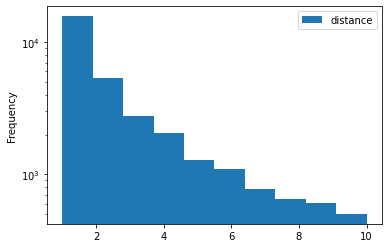

In [64]:
wn_df.plot.hist(logy=True)